In [1]:
import pandas as pd
import torch
from torch import nn 
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 
from sklearn.metrics import accuracy_score
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import pathlib
import os
import shutil
import PIL
import cv2
from tqdm import tqdm


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

In [6]:
input_dir = '/kaggle/input/yikes-spiders-15-species'  
output_dir = '/kaggle/working/'  

In [126]:
shutil.rmtree("/kaggle/working/train")    
shutil.rmtree("/kaggle/working/val")         
shutil.rmtree("/kaggle/working/test")

In [7]:
def copy_structure(src, dest):
    if not os.path.exists(dest):
        os.makedirs(dest)
    
    for dirpath, dirnames, filenames in os.walk(src):
        dest_path = dirpath.replace(src, dest, 1)
        if not os.path.exists(dest_path):
            os.makedirs(dest_path)
        
        for filename in tqdm(filenames):
            src_file = os.path.join(dirpath, filename)
            dest_file = os.path.join(dest_path, filename)
            shutil.copy2(src_file, dest_file)


In [127]:
copy_structure(os.path.join(input_dir, 'train'), os.path.join(output_dir, 'train'))
copy_structure(os.path.join(input_dir, 'test'), os.path.join(output_dir, 'test'))
copy_structure(os.path.join(input_dir, 'valid'), os.path.join(output_dir, 'val'))

0it [00:00, ?it/s]
100%|██████████| 154/154 [00:00<00:00, 388.76it/s]
0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 402.51it/s]
0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 488.61it/s]


In [129]:
train_data_link = "/kaggle/working/train"
val_data_link = "/kaggle/working/val"
test_data_link = "/kaggle/working/test"

train_data = pathlib.Path(train_data_link)
val_data = pathlib.Path(val_data_link)
test_data = pathlib.Path(test_data_link)

In [86]:
import os
from PIL import Image
import shutil

dir_ = '/kaggle/working/val'
num_copies = 3


for folder_name in os.listdir(dir_):
    folder_path = os.path.join(dir_, folder_name)
    if os.path.isdir(folder_path):

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                
                for i in range(1, num_copies + 1):
                    new_file_path = os.path.join(folder_path, f'{filename[:-4]}_copy_{i}.jpg')
                    shutil.copy(file_path, new_file_path)



In [87]:
import os
from PIL import Image
import shutil

dir_ = '/kaggle/working/train'
num_copies = 1


for folder_name in os.listdir(dir_):
    folder_path = os.path.join(dir_, folder_name)
    if os.path.isdir(folder_path):

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                
                for i in range(1, num_copies + 1):
                    new_file_path = os.path.join(folder_path, f'{filename[:-4]}_copy_{i}.jpg')
                    shutil.copy(file_path, new_file_path)



In [ ]:
list(train_data.glob("Black Widow/*"))

In [88]:
list_of_classes = os.listdir(train_data_link)
list_of_classes

['Black Widow',
 'Bold Jumper',
 'Blue Tarantula',
 'Peacock Spider',
 'Spiny-backed Orb-weaver',
 'Hobo Spider',
 'Red Knee Tarantula',
 'Huntsman Spider',
 'Yellow Garden Spider',
 'Ladybird Mimic Spider',
 'Brown Grass Spider',
 'Golden Orb Weaver',
 'White Kneed Tarantula',
 'Deinopis Spider',
 'Brown Recluse Spider']

In [78]:
def create_dict(lst, data):
    dictionary = {}
    for obj in lst:
        t_list = list(data.glob(f"{obj}/*"))
        dictionary[obj] = t_list
    return dictionary

In [131]:
train_dict = create_dict(list_of_classes, train_data)
val_dict = create_dict(list_of_classes, val_data)
test_dict = create_dict(list_of_classes, test_data)

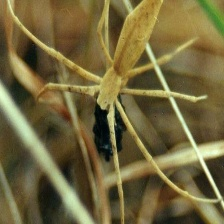

In [132]:
PIL.Image.open(str(train_dict["Deinopis Spider"][0]))

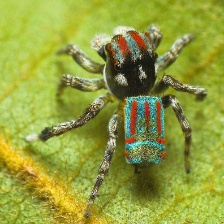

In [17]:
PIL.Image.open(str(train_dict["Peacock Spider"][0]))

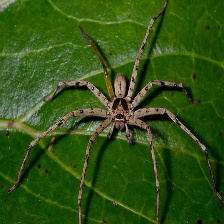

In [18]:
PIL.Image.open(str(train_dict["Huntsman Spider"][0]))

In [12]:
venomous_dict = {}

for obj in list_of_classes:
    if obj in ["Black Widow", "Brown Recluse Spider", "Hobo Spider"]:
        venomous_dict[obj] = 0
    elif obj in ["Golden Orb Weaver", "Huntsman Spider", "White Kneed Tarantula", "Red Knee Tarantula", "Blue Tarantula", "Spiny-backed Orb-weaver", "Blue Tarantula"]:
        venomous_dict[obj] = 1
    elif obj in ["Bold Jumper", "Deinopis Spider", "Ladybird Mimic Spider", "Peacock Spider", "Yellow Garden Spider", "Brown Grass Spider"]:
        venomous_dict[obj] = 2
        

classes_dict = {}

for num, obj in enumerate(list_of_classes):
    classes_dict[obj] = num
    


In [18]:
venomous_dict

{'Black Widow': 0,
 'Bold Jumper': 2,
 'Blue Tarantula': 1,
 'Peacock Spider': 2,
 'Spiny-backed Orb-weaver': 1,
 'Hobo Spider': 0,
 'Red Knee Tarantula': 1,
 'Huntsman Spider': 1,
 'Yellow Garden Spider': 2,
 'Ladybird Mimic Spider': 2,
 'Brown Grass Spider': 2,
 'Golden Orb Weaver': 1,
 'White Kneed Tarantula': 1,
 'Deinopis Spider': 2,
 'Brown Recluse Spider': 0}

In [19]:
classes_dict

{'Black Widow': 0,
 'Bold Jumper': 1,
 'Blue Tarantula': 2,
 'Peacock Spider': 3,
 'Spiny-backed Orb-weaver': 4,
 'Hobo Spider': 5,
 'Red Knee Tarantula': 6,
 'Huntsman Spider': 7,
 'Yellow Garden Spider': 8,
 'Ladybird Mimic Spider': 9,
 'Brown Grass Spider': 10,
 'Golden Orb Weaver': 11,
 'White Kneed Tarantula': 12,
 'Deinopis Spider': 13,
 'Brown Recluse Spider': 14}

In [16]:
def split_data(features_dict, label1_dict, label2_dict):
    x = []
    y1 = []
    y2 = []
    
    for name, images in features_dict.items():
        for image in images:
            image = cv2.imread(str(image))
            t_resized_image = cv2.resize(image, (256, 256))
            x.append(t_resized_image)
            y1.append(label1_dict[name])
            y2.append(label2_dict[name])
            
    return x, (y1, y2)

In [133]:
x_train, y_train = split_data(train_dict, classes_dict, venomous_dict)
x_val, y_val = split_data(val_dict, classes_dict, venomous_dict)
x_test, y_test = split_data(test_dict, classes_dict, venomous_dict)

In [27]:
danger_level = ["high", "meduim", "low"]

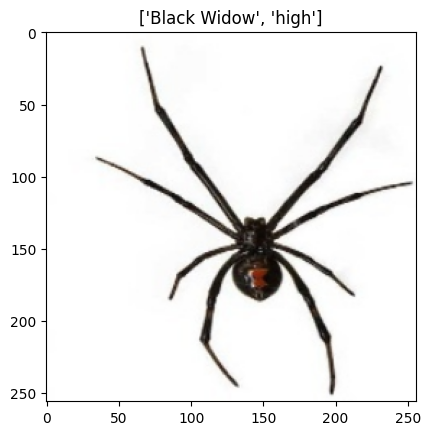

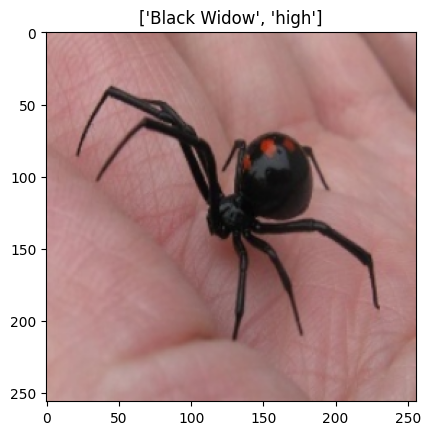

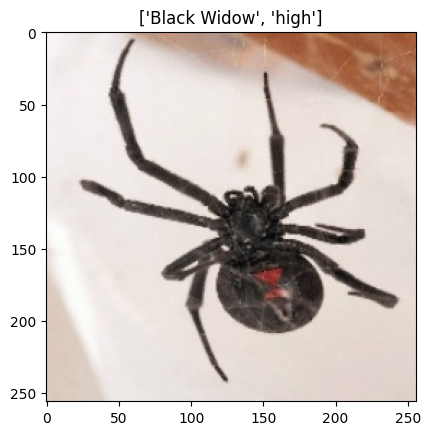

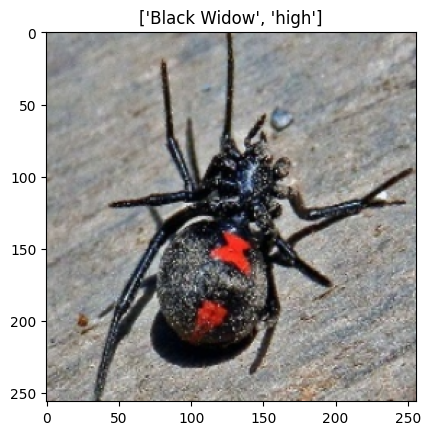

In [134]:
def output(x, y, num, lst1, lst2):
    for i in range(num):
        x[i] = cv2.cvtColor(x[i], cv2.COLOR_RGB2BGR)
        plt.imshow(x[i])
        plt.title([lst1[y[0][i]], lst2[y[1][i]]])
        plt.show()
        

output(x_train, y_train, 4, list_of_classes, danger_level)

In [135]:
train_transform = transforms.Compose([   
    transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))

])



val_transform = transforms.Compose([   
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [136]:
len(x_val), len(x_train)

(75, 2185)

In [137]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform):
        self.x_data = x_data
        self.y_data_class = torch.LongTensor(y_data[0]) 
        self.y_data_poisonous = torch.LongTensor(y_data[1])  
        self.transform = transform
       
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):        
        x = self.x_data[idx]
        x = x.astype(np.float32)
        x = x / 255.0
        
        if self.transform:
            x = self.transform(x)
        
        y_class = self.y_data_class[idx]
        y_poisonous = self.y_data_poisonous[idx]
        
        return x, (y_class, y_poisonous)

In [138]:
train_dataset = CustomDataset(x_train, y_train, transform = train_transform)
val_dataset = CustomDataset(x_val, y_val, transform = val_transform)
test_dataset = CustomDataset(x_test, y_test, transform = test_transform)

In [139]:
len(train_dataset)

2185

In [140]:
x, y = train_dataset[398]
x, y

(tensor([[[ 0.9988,  1.0502,  1.0844,  ...,  0.7419,  0.7248,  0.7077],
          [ 0.9474,  1.0159,  1.0502,  ...,  0.7419,  0.7419,  0.7248],
          [ 0.8961,  0.9646,  1.0159,  ...,  0.7591,  0.7591,  0.7419],
          ...,
          [-0.7650, -1.6384, -0.6623,  ..., -0.3541, -0.2171, -0.0972],
          [-0.0801, -1.3987, -0.7479,  ..., -0.4054, -0.2513, -0.1486],
          [ 0.1083, -0.4568,  0.5536,  ..., -0.4739, -0.3027, -0.1657]],
 
         [[ 1.1155,  1.1681,  1.2206,  ...,  0.9930,  0.9930,  0.9580],
          [ 1.0805,  1.1331,  1.1856,  ...,  0.9930,  0.9930,  0.9755],
          [ 1.0455,  1.1155,  1.1681,  ...,  1.0105,  1.0105,  0.9930],
          ...,
          [-0.5126, -1.4055, -0.4076,  ..., -0.7927, -0.6352, -0.5126],
          [ 0.1877, -1.1604, -0.4601,  ..., -0.8803, -0.7402, -0.6352],
          [ 0.3803, -0.1975,  0.8529,  ..., -0.9853, -0.8102, -0.6702]],
 
         [[ 1.3328,  1.3851,  1.4374,  ...,  1.1934,  1.1759,  1.1585],
          [ 1.2980,  1.3502,

In [141]:
for i in range(15):
    x, y = train_dataset[i]
    print(x.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


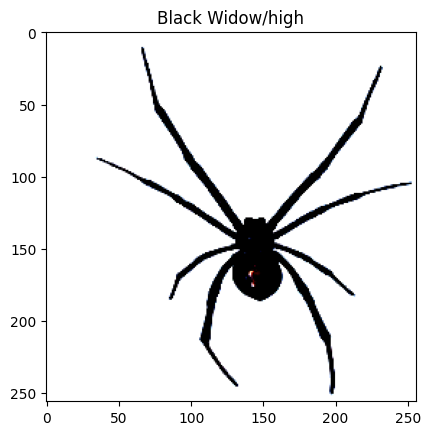

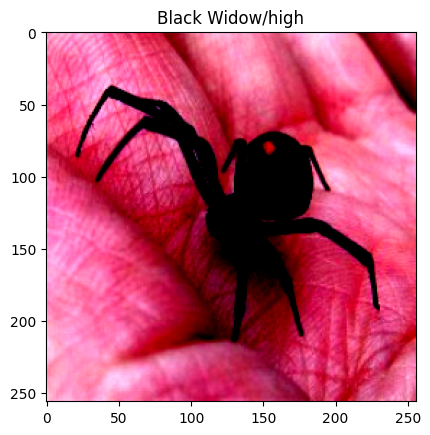

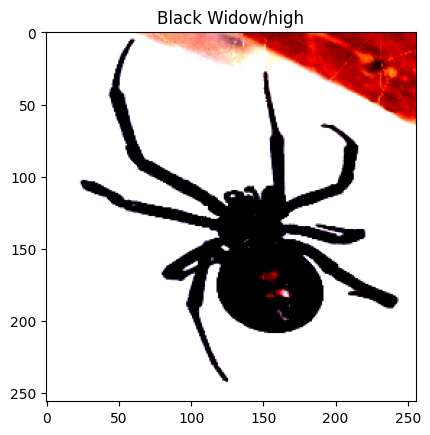

In [142]:
def output(dataset, itterations, names_list):
    for i in range(itterations):
        img, label = dataset[i]
        img = np.array(img)
        img = img.transpose(1, 2, 0)
        plt.title(names_list[label[0]] + "/" + danger_level[label[1]])
        plt.imshow(img)
        plt.show()
        
        
output(train_dataset, 3, list_of_classes)   

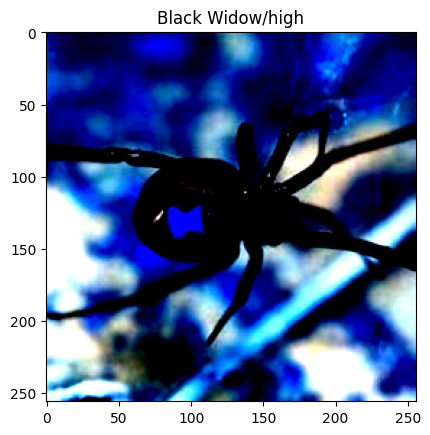

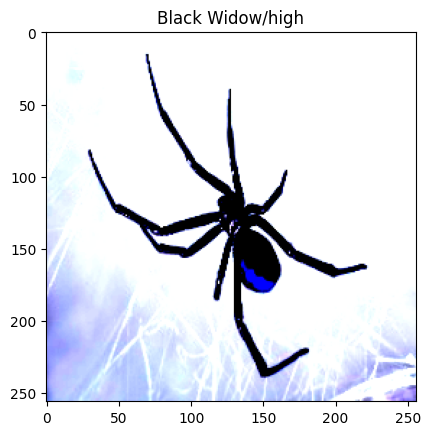

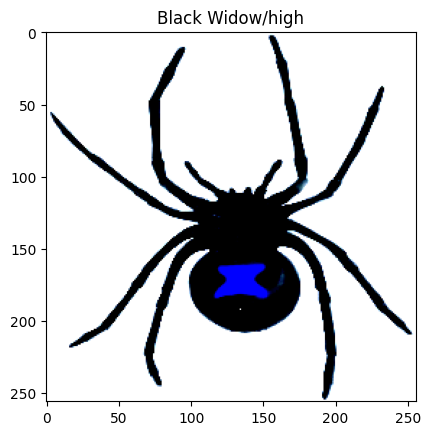

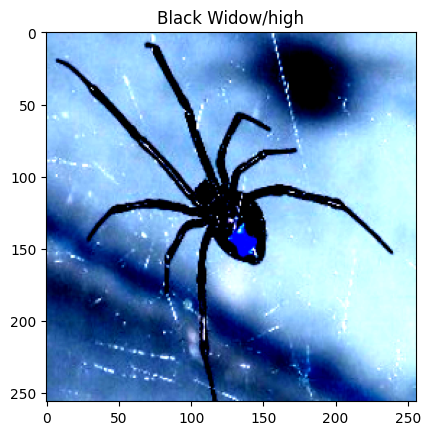

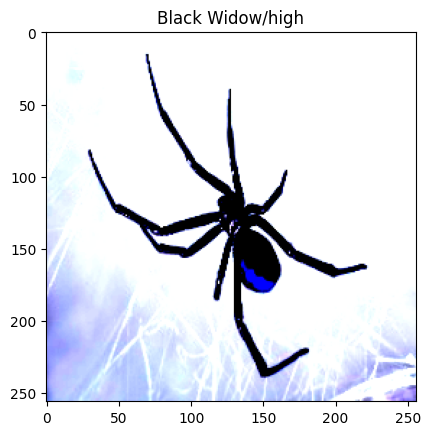

In [110]:
output(val_dataset, 5, list_of_classes)

In [143]:
bacth_size = 16

train_loader = DataLoader(
    train_dataset,              
    batch_size=bacth_size,        
    shuffle=True       
)

val_loader = DataLoader(
    val_dataset,              
    batch_size=bacth_size,        
    shuffle=True         
)

test_loader = DataLoader(
    test_dataset,              
    batch_size=bacth_size,        
    shuffle=True         
)

In [40]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, additional_conv = False, additional_pooling = False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding=1)
        
        if additional_conv == True:
            self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding=1)
        
        else:
            self.conv2 = None
        
        
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        if additional_pooling == True:
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        else: 
            self.pool2 = None 
            
    def forward(self, x):
        out = self.conv1(x)
        
        if self.conv2 is not None:
            out = F.relu(out)
            out = self.conv2(out)
            
        out = F.relu(out)
        
        out = self.pool1(out)
        out = F.relu(out)
        
        if self.pool2 is not None:
            out = self.pool2(out)
            out = F.relu(out)
        
        return out 
        

In [37]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_value=None, bnorm=False, output_layer=False):
        super().__init__()
        
        self.linear = nn.Linear(in_features, out_features)
        
        if dropout_value is not None:
            self.dropout = nn.Dropout(dropout_value)
        else:
            self.dropout = None
        
        if bnorm:
            self.bnorm = nn.BatchNorm1d(out_features)
        else:
            self.bnorm = None
        
        self.output_layer = output_layer
    
    def forward(self, x):
        out = self.linear(x)
        
        if self.bnorm is not None:
            out = self.bnorm(out)
        
        out = F.relu(out)
        
        if not self.output_layer and self.dropout is not None:
            out = self.dropout(out)

        
        return out


In [151]:
import torchvision.models as models


class CustomNetwork(nn.Module):
    def __init__(self, spider_classes = 15, venomous_levels = 3):
        super().__init__()
#         3, 256, 256
        self.conv_block1 = ConvBlock(3, 32, additional_pooling = True)
#         32, 64, 64
        self.conv_block2 = ConvBlock(32, 64, additional_pooling = False)
#         64, 16, 16
        self.conv_block3 = ConvBlock(64, 128, additional_pooling = False)
#         128, 4, 4 
        self.conv_block4 = ConvBlock(128, 256, additional_pooling = True)
#         256, 2, 2 
        self.conv_block5 = ConvBlock(256, 512, additional_pooling = True)
#         512, 1, 1
        self.flatten = nn.Flatten()
    
#       --------------------------------------------------------------------------------------------------------
        
    
        self.linear_block1_1 = LinearBlock(512, 256, dropout_value = 0.3, bnorm=True)
            
        self.linear_block1_2 = LinearBlock(256, 64, dropout_value = 0.3, bnorm=True)
        
        self.linear_block1_3 = LinearBlock(64, 32, dropout_value = 0.2, bnorm=True) 
        
        self.linear_block1_4 = LinearBlock(32, spider_classes, output_layer = True)
        
#       --------------------------------------------------------------------------------------------------------
        
        self.linear_block2_1 = LinearBlock(512, 256, dropout_value = 0.3, bnorm=True)
        
        self.linear_block2_2 = LinearBlock(256, 64, dropout_value = 0.3, bnorm=True)
        
        self.linear_block2_3 = LinearBlock(64, 32, dropout_value = 0.2, bnorm=True)
        
        self.linear_block2_4 = LinearBlock(32, 8, dropout_value = None, bnorm=True)
        
        self.linear_block2_5 = LinearBlock(8, venomous_levels, output_layer = True)
        
    
    def forward(self, x):
#         print(x.size())
        out = self.conv_block1(x)
#         print(out.size())
        out = self.conv_block2(out)
#         print(out.size())
        out = self.conv_block3(out)
#         print(out.size())
        out = self.conv_block4(out)
#         print(out.size())
        out = self.conv_block5(out)
#         print(out.size())
     

        fin_out = self.flatten(out)


        x1 = self.linear_block1_1(fin_out)
        x1 = self.linear_block1_2(x1)
        x1 = self.linear_block1_3(x1)
        out1 = self.linear_block1_4(x1)

        x2 = self.linear_block2_1(fin_out)
        x2 = self.linear_block2_2(x2)
        x2 = self.linear_block2_3(x2)
        x2 = self.linear_block2_4(x2)
        out2 = self.linear_block2_5(x2)
    

        return out1, out2
    
    
    def predict(self, x):
        self.eval()  

        with torch.no_grad(): 
            out1, out2 = self.forward(x)

            pred1 = F.softmax(out1, dim=1)  
            pred2 = F.softmax(out2, dim=1)  

            pred1 = torch.argmax(pred1, dim=1)
            pred2 = torch.argmax(pred2, dim=1)
        
        return pred1, pred2
    
    
model = CustomNetwork()
model.to(device)
    

CustomNetwork(
  (conv_block1): ConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_blo

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomNetwork(nn.Module):
    def __init__(self, spider_classes=15, venomous_levels=3):
        super(CustomNetwork, self).__init__()
        
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)

        # Полносвязные слои
        self.fc1 = nn.Linear(512 * 2 * 2, 256)  # Измените 8 на размер выходного тензора после сверточных слоев
        self.fc2 = nn.Linear(256, spider_classes)

        self.fc3 = nn.Linear(512 * 2 * 2, 256)  # Измените 8 на размер выходного тензора после сверточных слоев
        self.fc4 = nn.Linear(256, 32)
        self.fc5 = nn.Linear(32, venomous_levels)

        # Слои Dropout и BatchNorm
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(32)

        # Слой Flatten
        self.flatten = nn.Flatten()

    def forward(self, x):
        # Прямой проход через сверточные слои
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(x))
        x = self.pool(F.relu(self.conv5(x)))

        # Извлечение признаков с помощью Flatten
        x = self.flatten(x)  # Используем слой Flatten вместо view

        # Полносвязные слои для первой выходной переменной
        x1 = self.dropout(F.leaky_relu(self.fc1(x)))
        x1 = self.bn1(x1)
        out_1 = F.softmax(self.fc2(x1), dim=1)

        # Полносвязные слои для второй выходной переменной
        x2 = self.dropout(F.leaky_relu(self.fc3(x)))
        x2 = self.bn2(x2)
        x2 = self.dropout(F.leaky_relu(self.fc4(x2)))
        x2 = self.bn3(x2)
        out_2 = F.softmax(self.fc5(x2), dim=1)

        return out_1, out_2

# Создание модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomNetwork().to(device)

# Вызов summary
summary(model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
         MaxPool2d-9            [-1, 256, 8, 8]               0
        MaxPool2d-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 512, 4, 4]       1,180,160
        MaxPool2d-12            [-1, 512, 2, 2]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

In [43]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# import torch.nn.functional as F

# class CustomNetwork(nn.Module):
#     def __init__(self, spider_classes=15, venomous_levels=3):
#         super(CustomNetwork, self).__init__()
        
#         # Загрузка предобученной модели ResNet
#         self.base_model = models.resnet50(pretrained=True)
        
#         # Замена последнего слоя для классификации пауков
#         num_ftrs = self.base_model.fc.in_features
#         self.base_model.fc = nn.Identity()  # Убираем последний слой
        
#         # Создание линейного слоя для определения вида пауков
#         self.species_layer = nn.Linear(num_ftrs, spider_classes)
        
#         # Создание линейного слоя для определения ядовитости
#         self.toxicity_layer = nn.Linear(num_ftrs, venomous_levels)
        
#     def forward(self, x):
#         # Получаем выходы из базовой модели
#         features = self.base_model(x)  # Размер выхода: (batch_size, 2048)
        
#         # Прогоняем через слои для классификации
#         out_species = self.species_layer(features)  # Для вида пауков
#         out_toxicity = self.toxicity_layer(features)  # Для ядовитости
        
#         return out_species, out_toxicity
    
#     def predict(self, x):
#         self.eval()
#         with torch.no_grad():
#             out_species, out_toxicity = self.forward(x)
#             pred_species = torch.argmax(F.softmax(out_species, dim=1), dim=1)
#             pred_toxicity = torch.argmax(F.softmax(out_toxicity, dim=1), dim=1)
#         return pred_species, pred_toxicity

# # Пример использования
# model = CustomNetwork(spider_classes=15, venomous_levels=3)
# model.to(device)

# # Проверка структуры модели
# from torchsummary import summary
# summary(model, input_size=(3, 256, 256))


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.4MB/s]


ModuleNotFoundError: No module named 'torchsummary'

In [65]:
# input_tensor = torch.randn(32, 3, 256, 256)  # пример входного тензора с размером (batch_size, channels, height, width)
# # input_tensor = input_tensor.to(device)
# model.eval()
# output = model(input_tensor)

In [157]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, momentum=0.5)

In [47]:
!pip install -q torchsummary

In [63]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]         295,168
         MaxPool2d-9            [-1, 256, 8, 8]               0
        MaxPool2d-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 512, 4, 4]       1,180,160
        MaxPool2d-12            [-1, 512, 2, 2]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

In [146]:
import time
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

def train(model, optimizer, loss_fn1, loss_fn2, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression', l1_lambda=0.001, l2_lambda=0.001):
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [f'metric_{i + 1}' for i in range(len(metrics))]

    if len(metrics_name) < 2:
        raise ValueError(f'Expected at least 2 metrics names, but got {len(metrics_name)}')

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()
    
    
# --------------------------------------------------------------------------------------------------------

    for epoch in range(epochs):
        start_time_epoch = time.time()
        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}
        
#         class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0])
#         class_weights = class_weights.to(device)
#         loss_fn_species = nn.CrossEntropyLoss(weight=class_weights)  # Для классификации видов
#         loss_fn_toxicity = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0, 1.0, 2.0]).to(device))  

        for batch in tqdm(train_dl):
            x = batch[0].to(device)
            y1, y2 = batch[1]  # Разделение меток на две категории
            y1 = y1.to(device)
            y2 = y2.to(device)

            new_x = x.permute(0, 1, 2, 3)
            x_tensor = new_x.clone().detach()

            y_pred1, y_pred2 = model(x_tensor)

            loss1 = loss_fn1(y_pred1, y1)
            loss2 = loss_fn2(y_pred2, y2)
            loss = loss1 + loss2 
            
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss += l2_lambda * l2_norm
            
#             l2_norm = sum(p.pow(2).sum() for p in model.parameters())
#             l1_norm = sum(p.abs().sum() for p in model.parameters())
#             loss += l2_lambda * l2_norm + l1_lambda * l1_norm
    
    
#             l1_norm = sum(p.abs().sum() for p in model.parameters())
#             loss += l1_lambda * l1_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Сбор метрик
            history_train['loss'] += loss.item() * x.size(0)
            for i, (y_true, y_pred) in enumerate(zip([y1, y2], [y_pred1, y_pred2])):
                if i >= len(metrics_name):
                    break
                name = metrics_name[i]

                try:
                    y_true_np = y_true.cpu().numpy()
                    y_pred_np = y_pred.detach().cpu().numpy()

                    # Убедимся, что y_pred имеет правильную форму
                    if task == 'multiclass':
                        y_pred_np = y_pred_np.argmax(axis=-1)

                    history_train[name] += metrics[i](y_true_np, y_pred_np) * x.size(0)

                except Exception as e:
                    print(f"Error during metric calculation for {name}: {e}")

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in tqdm(val_dl):
                x = batch[0].to(device)
                y1, y2 = batch[1]
                y1 = y1.to(device)
                y2 = y2.to(device)

                new_x = x.permute(0, 1, 2, 3)
                x_tensor = new_x.clone().detach()

                y_pred1, y_pred2 = model(x_tensor)

                loss1 = loss_fn1(y_pred1, y1)
                loss2 = loss_fn2(y_pred2, y2)
                loss = loss1 + loss2 
                
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += l2_lambda * l2_norm
                    
#                 l2_norm = sum(p.pow(2).sum() for p in model.parameters())
#                 l1_norm = sum(p.abs().sum() for p in model.parameters())
#                 loss += l2_lambda * l2_norm + l1_lambda * l1_norm
                

                history_val['val_loss'] += loss.item() * x.size(0)

                for i, (y_true, y_pred) in enumerate(zip([y1, y2], [y_pred1, y_pred2])):
                    if i >= len(metrics_name):
                        break
                    name = metrics_name[i]

                    # Использование .cpu() для меток перед преобразованием в NumPy
                    y_true_np = y_true.cpu().numpy()
                    y_pred_np = y_pred.detach().cpu().numpy()

                    # Убедимся, что y_pred имеет правильную форму
                    if task == 'multiclass':
                        y_pred_np = y_pred_np.argmax(axis=-1)

                    history_val['val_' + name] += metrics[i](y_true_np, y_pred_np) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS
        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = time.time() - start_time_epoch
        print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
        print()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [169]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# Предположим, что у вас есть тестовый даталоадер и функция потерь
criterion = torch.nn.CrossEntropyLoss()  # Замените на вашу функцию потерь

total_loss_task1 = 0.0
total_loss_task2 = 0.0
total_accuracy_task1 = 0.0
total_accuracy_task2 = 0.0

model.eval()

with torch.no_grad():  
    for x_batch, y_batch in test_loader:
        all_predictions = model(x_batch)

        y_pred_task1 = all_predictions[0]  
        y_pred_task2 = all_predictions[1]

        all_true_labels_task1 = y_batch[0] 
        all_true_labels_task2 = y_batch[1]  

        loss_task1 = criterion(y_pred_task1, all_true_labels_task1)
        loss_task2 = criterion(y_pred_task2, all_true_labels_task2)

        total_loss_task1 += loss_task1.item()
        total_loss_task2 += loss_task2.item()


        y_pred_task1_labels = torch.argmax(y_pred_task1, dim=1)
        accuracy_task1 = accuracy_score(all_true_labels_task1.numpy(), y_pred_task1_labels.numpy())
        total_accuracy_task1 += accuracy_task1
        
        y_pred_task2_labels = torch.argmax(y_pred_task2, dim=1)
        accuracy_task2 = accuracy_score(all_true_labels_task2.numpy(), y_pred_task2_labels.numpy())
        total_accuracy_task2 += accuracy_task2


num_batches = len(test_loader)
average_loss_task1 = total_loss_task1 / num_batches
average_loss_task2 = total_loss_task2 / num_batches
average_accuracy_task1 = total_accuracy_task1 / num_batches
average_accuracy_task2 = total_accuracy_task2 / num_batches

print(f"Average Loss for Task 1: {average_loss_task1:.4f}, Average Accuracy: {average_accuracy_task1:.4f}")
print(f"Average Loss for Task 2: {average_loss_task2:.4f}, Average Accuracy: {average_accuracy_task2:.4f}")


Average Loss for Task 1: 1.2706, Average Accuracy: 0.6159
Average Loss for Task 2: 0.6608, Average Accuracy: 0.7898


In [158]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, loss_fn, train_loader, val_loader,
                epochs=100,
                metrics=[accuracy_score, accuracy_score],
                device=device,
                task='multiclass')

train() called: model=CustomNetwork, opt=RMSprop(lr=0.001000), epochs=100, device=cuda



100%|██████████| 5/5 [00:00<00:00, 53.87it/s]


Epoch    1    5sec	loss:       3.22	val_loss:       2.93	metric_1:      0.527	val_metric_1:       0.56	metric_2:      0.747	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 53.22it/s]


Epoch    2    5sec	loss:       1.78	val_loss:       2.92	metric_1:      0.783	val_metric_1:      0.613	metric_2:      0.928	val_metric_2:      0.707	


100%|██████████| 5/5 [00:00<00:00, 53.92it/s]


Epoch    3    5sec	loss:        1.6	val_loss:       4.59	metric_1:      0.789	val_metric_1:      0.493	metric_2:      0.946	val_metric_2:       0.56	


100%|██████████| 5/5 [00:00<00:00, 53.70it/s]


Epoch    4    5sec	loss:       1.55	val_loss:       2.09	metric_1:      0.805	val_metric_1:       0.68	metric_2:      0.946	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 54.08it/s]


Epoch    5    5sec	loss:       1.48	val_loss:       2.29	metric_1:      0.815	val_metric_1:      0.667	metric_2:      0.957	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 53.69it/s]


Epoch    6    5sec	loss:       1.43	val_loss:       2.33	metric_1:       0.82	val_metric_1:      0.693	metric_2:      0.957	val_metric_2:      0.787	


100%|██████████| 5/5 [00:00<00:00, 54.61it/s]


Epoch    7    5sec	loss:       1.46	val_loss:       3.21	metric_1:      0.814	val_metric_1:      0.587	metric_2:      0.963	val_metric_2:      0.773	


100%|██████████| 5/5 [00:00<00:00, 53.92it/s]


Epoch    8    5sec	loss:       1.39	val_loss:       2.36	metric_1:      0.825	val_metric_1:      0.667	metric_2:      0.967	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 53.98it/s]


Epoch    9    5sec	loss:       1.39	val_loss:       3.39	metric_1:      0.825	val_metric_1:      0.547	metric_2:      0.968	val_metric_2:       0.68	


100%|██████████| 5/5 [00:00<00:00, 53.80it/s]


Epoch   10    5sec	loss:       1.39	val_loss:       4.13	metric_1:      0.835	val_metric_1:       0.56	metric_2:      0.959	val_metric_2:        0.6	


100%|██████████| 5/5 [00:00<00:00, 55.18it/s]


Epoch   11    5sec	loss:       1.35	val_loss:       2.62	metric_1:      0.834	val_metric_1:      0.667	metric_2:      0.974	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 55.12it/s]


Epoch   12    5sec	loss:       1.38	val_loss:       3.84	metric_1:      0.833	val_metric_1:       0.48	metric_2:      0.973	val_metric_2:       0.68	


100%|██████████| 5/5 [00:00<00:00, 53.53it/s]


Epoch   13    5sec	loss:        1.4	val_loss:       2.89	metric_1:      0.831	val_metric_1:        0.6	metric_2:      0.962	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 44.88it/s]


Epoch   14    5sec	loss:       1.44	val_loss:       2.18	metric_1:      0.816	val_metric_1:      0.707	metric_2:      0.966	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 55.44it/s]


Epoch   15    5sec	loss:       1.34	val_loss:       2.15	metric_1:      0.839	val_metric_1:       0.76	metric_2:      0.972	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 53.73it/s]


Epoch   16    5sec	loss:       1.34	val_loss:       2.45	metric_1:      0.841	val_metric_1:       0.68	metric_2:      0.974	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 50.73it/s]


Epoch   17    5sec	loss:       1.36	val_loss:       2.61	metric_1:       0.84	val_metric_1:      0.667	metric_2:      0.972	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 52.97it/s]


Epoch   18    5sec	loss:       1.34	val_loss:       2.57	metric_1:      0.848	val_metric_1:      0.613	metric_2:      0.972	val_metric_2:      0.853	


100%|██████████| 5/5 [00:00<00:00, 45.75it/s]


Epoch   19    5sec	loss:       1.34	val_loss:       2.58	metric_1:       0.84	val_metric_1:       0.56	metric_2:      0.967	val_metric_2:       0.88	


100%|██████████| 5/5 [00:00<00:00, 54.66it/s]


Epoch   20    5sec	loss:       1.37	val_loss:       2.44	metric_1:       0.84	val_metric_1:       0.68	metric_2:      0.972	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 52.05it/s]


Epoch   21    5sec	loss:       1.28	val_loss:       2.42	metric_1:       0.86	val_metric_1:       0.72	metric_2:       0.98	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 53.36it/s]


Epoch   22    5sec	loss:       1.27	val_loss:       4.71	metric_1:      0.849	val_metric_1:      0.307	metric_2:      0.983	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 50.74it/s]


Epoch   23    5sec	loss:       1.37	val_loss:       3.08	metric_1:      0.833	val_metric_1:      0.667	metric_2:      0.968	val_metric_2:       0.72	


100%|██████████| 5/5 [00:00<00:00, 53.13it/s]


Epoch   24    5sec	loss:       1.32	val_loss:       2.69	metric_1:      0.855	val_metric_1:      0.613	metric_2:      0.979	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 52.67it/s]


Epoch   25    5sec	loss:       1.34	val_loss:       9.75	metric_1:      0.846	val_metric_1:      0.333	metric_2:      0.976	val_metric_2:        0.4	


100%|██████████| 5/5 [00:00<00:00, 52.60it/s]


Epoch   26    5sec	loss:       1.35	val_loss:       2.96	metric_1:      0.847	val_metric_1:      0.627	metric_2:      0.971	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 52.62it/s]


Epoch   27    5sec	loss:       1.32	val_loss:       2.78	metric_1:      0.842	val_metric_1:       0.56	metric_2:      0.985	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 53.73it/s]


Epoch   28    5sec	loss:       1.29	val_loss:       2.64	metric_1:      0.854	val_metric_1:      0.653	metric_2:      0.973	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 53.52it/s]


Epoch   29    5sec	loss:       1.29	val_loss:       2.58	metric_1:       0.86	val_metric_1:      0.667	metric_2:      0.975	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 52.63it/s]


Epoch   30    5sec	loss:       1.28	val_loss:        3.2	metric_1:      0.864	val_metric_1:      0.547	metric_2:      0.979	val_metric_2:      0.787	


100%|██████████| 5/5 [00:00<00:00, 54.16it/s]


Epoch   31    5sec	loss:       1.33	val_loss:       2.62	metric_1:      0.862	val_metric_1:       0.68	metric_2:      0.967	val_metric_2:      0.773	


100%|██████████| 5/5 [00:00<00:00, 52.90it/s]


Epoch   32    5sec	loss:       1.25	val_loss:        2.1	metric_1:      0.867	val_metric_1:      0.733	metric_2:      0.984	val_metric_2:      0.867	


100%|██████████| 5/5 [00:00<00:00, 53.03it/s]


Epoch   33    5sec	loss:       1.29	val_loss:       2.29	metric_1:      0.857	val_metric_1:       0.68	metric_2:      0.982	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 54.37it/s]


Epoch   34    5sec	loss:        1.3	val_loss:       2.51	metric_1:      0.871	val_metric_1:      0.587	metric_2:      0.975	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 55.12it/s]


Epoch   35    5sec	loss:       1.28	val_loss:       2.39	metric_1:       0.87	val_metric_1:      0.667	metric_2:      0.973	val_metric_2:       0.88	


100%|██████████| 5/5 [00:00<00:00, 53.63it/s]


Epoch   36    5sec	loss:       1.19	val_loss:       2.33	metric_1:      0.874	val_metric_1:       0.68	metric_2:      0.989	val_metric_2:      0.787	


100%|██████████| 5/5 [00:00<00:00, 53.15it/s]


Epoch   37    5sec	loss:       1.35	val_loss:       3.25	metric_1:      0.859	val_metric_1:      0.613	metric_2:      0.964	val_metric_2:      0.693	


100%|██████████| 5/5 [00:00<00:00, 53.34it/s]


Epoch   38    5sec	loss:       1.29	val_loss:        2.3	metric_1:       0.87	val_metric_1:      0.693	metric_2:      0.974	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 40.45it/s]


Epoch   39    5sec	loss:       1.21	val_loss:       2.68	metric_1:      0.886	val_metric_1:      0.707	metric_2:      0.989	val_metric_2:      0.773	


100%|██████████| 5/5 [00:00<00:00, 47.81it/s]


Epoch   40    5sec	loss:       1.32	val_loss:       2.32	metric_1:      0.862	val_metric_1:      0.667	metric_2:      0.975	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 52.16it/s]


Epoch   41    5sec	loss:       1.25	val_loss:       3.92	metric_1:      0.872	val_metric_1:      0.493	metric_2:      0.977	val_metric_2:       0.68	


100%|██████████| 5/5 [00:00<00:00, 54.20it/s]


Epoch   42    5sec	loss:       1.26	val_loss:       2.26	metric_1:      0.867	val_metric_1:      0.667	metric_2:      0.978	val_metric_2:       0.88	


100%|██████████| 5/5 [00:00<00:00, 56.61it/s]


Epoch   43    5sec	loss:       1.22	val_loss:       3.26	metric_1:      0.876	val_metric_1:      0.587	metric_2:      0.985	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 55.03it/s]


Epoch   44    5sec	loss:       1.31	val_loss:       3.01	metric_1:      0.865	val_metric_1:        0.6	metric_2:      0.971	val_metric_2:      0.667	


100%|██████████| 5/5 [00:00<00:00, 55.85it/s]


Epoch   45    5sec	loss:       1.22	val_loss:        5.2	metric_1:      0.878	val_metric_1:       0.64	metric_2:      0.982	val_metric_2:      0.427	


100%|██████████| 5/5 [00:00<00:00, 53.90it/s]


Epoch   46    5sec	loss:       1.21	val_loss:       2.91	metric_1:      0.887	val_metric_1:       0.64	metric_2:      0.977	val_metric_2:      0.707	


100%|██████████| 5/5 [00:00<00:00, 54.50it/s]


Epoch   47    5sec	loss:       1.25	val_loss:       2.47	metric_1:      0.879	val_metric_1:      0.653	metric_2:      0.982	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 54.99it/s]


Epoch   48    5sec	loss:       1.29	val_loss:       2.29	metric_1:       0.87	val_metric_1:      0.707	metric_2:      0.975	val_metric_2:      0.867	


100%|██████████| 5/5 [00:00<00:00, 52.28it/s]


Epoch   49    5sec	loss:       1.26	val_loss:       2.07	metric_1:      0.877	val_metric_1:      0.733	metric_2:      0.975	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 53.27it/s]


Epoch   50    5sec	loss:       1.22	val_loss:       2.69	metric_1:      0.887	val_metric_1:        0.6	metric_2:      0.983	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 54.93it/s]


Epoch   51    5sec	loss:       1.16	val_loss:       2.38	metric_1:      0.897	val_metric_1:      0.653	metric_2:      0.984	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 54.03it/s]


Epoch   52    5sec	loss:       1.27	val_loss:       3.97	metric_1:      0.868	val_metric_1:      0.533	metric_2:      0.982	val_metric_2:       0.68	


100%|██████████| 5/5 [00:00<00:00, 54.55it/s]


Epoch   53    5sec	loss:        1.3	val_loss:       2.57	metric_1:      0.869	val_metric_1:      0.627	metric_2:      0.975	val_metric_2:      0.867	


100%|██████████| 5/5 [00:00<00:00, 53.57it/s]


Epoch   54    5sec	loss:       1.22	val_loss:       2.53	metric_1:      0.876	val_metric_1:       0.76	metric_2:      0.983	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 53.23it/s]


Epoch   55    5sec	loss:       1.18	val_loss:       2.71	metric_1:      0.889	val_metric_1:      0.587	metric_2:      0.989	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 52.26it/s]


Epoch   56    5sec	loss:       1.19	val_loss:       3.34	metric_1:      0.886	val_metric_1:      0.547	metric_2:       0.99	val_metric_2:      0.693	


100%|██████████| 5/5 [00:00<00:00, 53.12it/s]


Epoch   57    5sec	loss:       1.26	val_loss:       2.59	metric_1:      0.872	val_metric_1:      0.627	metric_2:      0.982	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 51.40it/s]


Epoch   58    5sec	loss:       1.24	val_loss:       2.27	metric_1:      0.877	val_metric_1:       0.68	metric_2:       0.98	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 54.18it/s]


Epoch   59    5sec	loss:       1.33	val_loss:       5.24	metric_1:      0.868	val_metric_1:      0.493	metric_2:      0.969	val_metric_2:       0.56	


100%|██████████| 5/5 [00:00<00:00, 51.87it/s]


Epoch   60    5sec	loss:       1.21	val_loss:       4.81	metric_1:      0.887	val_metric_1:       0.48	metric_2:      0.986	val_metric_2:      0.547	


100%|██████████| 5/5 [00:00<00:00, 54.76it/s]


Epoch   61    5sec	loss:       1.18	val_loss:       1.87	metric_1:      0.885	val_metric_1:      0.787	metric_2:      0.989	val_metric_2:      0.853	


100%|██████████| 5/5 [00:00<00:00, 54.00it/s]


Epoch   62    5sec	loss:       1.18	val_loss:       3.14	metric_1:      0.892	val_metric_1:      0.627	metric_2:      0.981	val_metric_2:       0.72	


100%|██████████| 5/5 [00:00<00:00, 51.96it/s]


Epoch   63    5sec	loss:       1.29	val_loss:       2.79	metric_1:      0.879	val_metric_1:      0.653	metric_2:      0.969	val_metric_2:      0.747	


100%|██████████| 5/5 [00:00<00:00, 54.69it/s]


Epoch   64    5sec	loss:       1.21	val_loss:       2.77	metric_1:      0.887	val_metric_1:        0.6	metric_2:      0.982	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 54.85it/s]


Epoch   65    5sec	loss:       1.18	val_loss:       2.34	metric_1:      0.895	val_metric_1:      0.667	metric_2:      0.981	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 45.45it/s]


Epoch   66    5sec	loss:       1.14	val_loss:       2.32	metric_1:      0.888	val_metric_1:       0.68	metric_2:       0.99	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 53.93it/s]


Epoch   67    5sec	loss:       1.25	val_loss:       2.19	metric_1:      0.881	val_metric_1:      0.693	metric_2:      0.976	val_metric_2:      0.853	


100%|██████████| 5/5 [00:00<00:00, 55.18it/s]


Epoch   68    5sec	loss:       1.24	val_loss:       2.97	metric_1:      0.886	val_metric_1:       0.64	metric_2:      0.976	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 53.81it/s]


Epoch   69    5sec	loss:       1.18	val_loss:       2.07	metric_1:      0.888	val_metric_1:      0.733	metric_2:      0.987	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 53.42it/s]


Epoch   70    5sec	loss:       1.21	val_loss:       2.22	metric_1:      0.886	val_metric_1:      0.693	metric_2:      0.977	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 53.66it/s]


Epoch   71    5sec	loss:       1.17	val_loss:       3.64	metric_1:      0.899	val_metric_1:      0.613	metric_2:      0.979	val_metric_2:      0.813	


100%|██████████| 5/5 [00:00<00:00, 54.22it/s]


Epoch   72    5sec	loss:       1.22	val_loss:       2.46	metric_1:      0.888	val_metric_1:      0.707	metric_2:      0.982	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 56.63it/s]


Epoch   73    5sec	loss:        1.2	val_loss:       2.17	metric_1:       0.89	val_metric_1:       0.72	metric_2:      0.981	val_metric_2:      0.853	


100%|██████████| 5/5 [00:00<00:00, 54.30it/s]


Epoch   74    5sec	loss:        1.2	val_loss:       2.37	metric_1:      0.886	val_metric_1:       0.72	metric_2:       0.98	val_metric_2:      0.787	


100%|██████████| 5/5 [00:00<00:00, 55.38it/s]


Epoch   75    5sec	loss:       1.18	val_loss:       6.42	metric_1:      0.896	val_metric_1:      0.347	metric_2:      0.983	val_metric_2:      0.547	


100%|██████████| 5/5 [00:00<00:00, 54.83it/s]


Epoch   76    5sec	loss:       1.18	val_loss:       3.52	metric_1:      0.881	val_metric_1:      0.613	metric_2:      0.984	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 53.62it/s]


Epoch   77    5sec	loss:        1.2	val_loss:       2.61	metric_1:      0.885	val_metric_1:       0.64	metric_2:      0.978	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 54.25it/s]


Epoch   78    5sec	loss:       1.18	val_loss:       2.87	metric_1:      0.893	val_metric_1:      0.613	metric_2:      0.979	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 54.26it/s]


Epoch   79    5sec	loss:       1.25	val_loss:        2.9	metric_1:      0.879	val_metric_1:        0.6	metric_2:      0.977	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 52.93it/s]


Epoch   80    5sec	loss:       1.19	val_loss:       2.11	metric_1:      0.896	val_metric_1:       0.76	metric_2:      0.982	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 55.81it/s]


Epoch   81    5sec	loss:       1.19	val_loss:       2.74	metric_1:      0.895	val_metric_1:      0.653	metric_2:      0.981	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 52.82it/s]


Epoch   82    5sec	loss:        1.2	val_loss:       4.92	metric_1:      0.889	val_metric_1:      0.333	metric_2:      0.983	val_metric_2:       0.72	


100%|██████████| 5/5 [00:00<00:00, 45.34it/s]


Epoch   83    5sec	loss:       1.23	val_loss:       2.47	metric_1:      0.876	val_metric_1:      0.667	metric_2:      0.978	val_metric_2:       0.76	


100%|██████████| 5/5 [00:00<00:00, 52.88it/s]


Epoch   84    5sec	loss:       1.19	val_loss:       3.96	metric_1:      0.885	val_metric_1:      0.507	metric_2:      0.987	val_metric_2:      0.613	


100%|██████████| 5/5 [00:00<00:00, 53.61it/s]


Epoch   85    5sec	loss:       1.23	val_loss:       2.44	metric_1:      0.888	val_metric_1:       0.72	metric_2:      0.972	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 52.93it/s]


Epoch   86    5sec	loss:       1.21	val_loss:       2.42	metric_1:      0.891	val_metric_1:      0.627	metric_2:       0.98	val_metric_2:      0.773	


100%|██████████| 5/5 [00:00<00:00, 55.15it/s]


Epoch   87    5sec	loss:       1.19	val_loss:       2.26	metric_1:      0.894	val_metric_1:      0.693	metric_2:      0.984	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 55.60it/s]


Epoch   88    5sec	loss:       1.22	val_loss:       2.22	metric_1:       0.89	val_metric_1:      0.667	metric_2:      0.984	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 53.36it/s]


Epoch   89    5sec	loss:       1.11	val_loss:       3.02	metric_1:      0.909	val_metric_1:      0.573	metric_2:      0.993	val_metric_2:      0.773	


100%|██████████| 5/5 [00:00<00:00, 53.89it/s]


Epoch   90    5sec	loss:       1.19	val_loss:       5.14	metric_1:      0.887	val_metric_1:       0.44	metric_2:      0.977	val_metric_2:      0.707	


100%|██████████| 5/5 [00:00<00:00, 55.09it/s]


Epoch   91    5sec	loss:       1.24	val_loss:       2.21	metric_1:      0.879	val_metric_1:      0.707	metric_2:      0.975	val_metric_2:       0.84	


100%|██████████| 5/5 [00:00<00:00, 53.24it/s]


Epoch   92    5sec	loss:       1.16	val_loss:       2.11	metric_1:      0.889	val_metric_1:       0.72	metric_2:      0.987	val_metric_2:        0.8	


100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Epoch   93    5sec	loss:       1.17	val_loss:       2.63	metric_1:      0.892	val_metric_1:      0.667	metric_2:       0.98	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 54.15it/s]


Epoch   94    5sec	loss:       1.22	val_loss:       2.41	metric_1:      0.886	val_metric_1:      0.693	metric_2:       0.97	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 53.73it/s]


Epoch   95    5sec	loss:       1.11	val_loss:       5.32	metric_1:      0.905	val_metric_1:      0.547	metric_2:      0.993	val_metric_2:        0.4	


100%|██████████| 5/5 [00:00<00:00, 55.17it/s]


Epoch   96    5sec	loss:       1.15	val_loss:       3.28	metric_1:      0.902	val_metric_1:        0.6	metric_2:      0.982	val_metric_2:      0.787	


100%|██████████| 5/5 [00:00<00:00, 54.47it/s]


Epoch   97    5sec	loss:       1.12	val_loss:       2.71	metric_1:      0.907	val_metric_1:       0.64	metric_2:      0.982	val_metric_2:      0.773	


100%|██████████| 5/5 [00:00<00:00, 55.47it/s]


Epoch   98    5sec	loss:       1.13	val_loss:       2.29	metric_1:      0.903	val_metric_1:       0.72	metric_2:      0.987	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 54.59it/s]


Epoch   99    5sec	loss:        1.2	val_loss:        2.7	metric_1:      0.882	val_metric_1:        0.6	metric_2:      0.984	val_metric_2:      0.827	


100%|██████████| 5/5 [00:00<00:00, 56.09it/s]

Epoch  100    5sec	loss:       1.16	val_loss:       2.57	metric_1:      0.894	val_metric_1:      0.653	metric_2:      0.985	val_metric_2:      0.827	
Time total:     510.40 sec


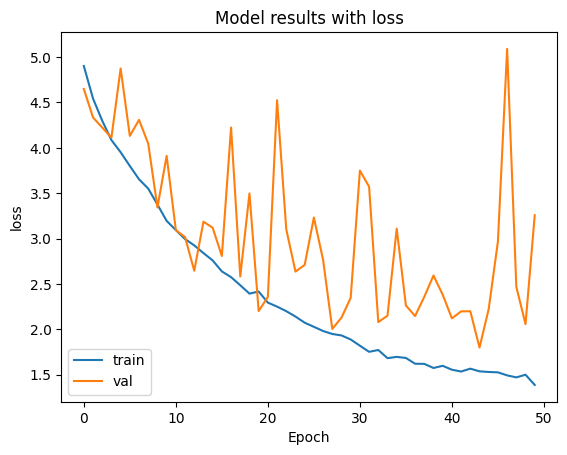

In [155]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

In [171]:
len(train_dataset), len(val_dataset)

(2185, 75)